In [ ]:
import sys
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import urllib
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img

In [ ]:
CWD_PATH = os.getcwd()
# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'mask_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
PATH_TO_CKPT = os.path.join(CWD_PATH, 'modules', MODEL_NAME, 'frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(CWD_PATH, '../../tensorflow', 'models', 'research', 'object_detection', 'data', 'mscoco_label_map.pbtxt')
IMAGE_SIZE = (12, 8)

In [ ]:
sys.path.append(os.path.join(CWD_PATH, '../../tensorflow','models', 'research'))
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)
    ).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [5]:
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [11]:
def crop_single_image(image_path):
    image = load_img(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    indices = np.where(output_dict['detection_classes'] == 3)
    index = indices[0][0]

    box = output_dict['detection_boxes'][index]
    w, h = image.size

    box = (box[1] * w, box[0] * h, box[3] * w, box[2] * h)
    
    mask = output_dict['detection_masks'][index]
    mask = np.stack([mask, mask, mask], axis=2)
    
    output_img = image_np * mask
    output_img = array_to_img(output_img)
    output_img = output_img.crop(box)
    output_img = load_image_into_numpy_array(output_img)
    
    return output_img, output_dict

def filter_files(files_list, filter_by = None):
    try:
        files_list.remove('.DS_Store')
    except:
        x=1
        
    if filter_by is not None:
        mask = np.logical_not(np.isin(files_list, filter_by))
        result = []
        for f, m in zip(files_list, mask):
            if m == True:
                result.append(f)

        return result
    else:
        return files_list

def crop_dir(source_path, target_path, directory):
    if os.path.exists(target_path + directory) == False:
        os.mkdir(target_path + directory)
    
    filenames = os.listdir(source_path + directory)
    filenames = filter_files(filenames)
    
    for filename in filenames:
        img, _ = crop_single_image(source_path + directory + '/' + filename)
        print(img.shape)
        img = array_to_img(img)
        save_img(target_path + directory + '/' + filename, img)
    
def crop(source_path, target_path, dirs):
    target_dirs = os.listdir(target_path)
    dirs = filter_files(dirs, target_dirs)

    if os.path.exists(target_path) == False:
        os.mkdir(target_path)
    
    for i, directory in enumerate(dirs):
        print('Directory', str(i), 'of', str(len(dirs)), '...')
        crop_dir(source_path, target_path, directory)
        print('Images in directory', str(i), '"' + directory + '"', 'cropped')

In [ ]:
dirs = ['Bentley Continental_Flying_Spur Sedan 2007',
 'Audi TT Coupe 2012 RS',
 'Buick Rainier SUV 2007',
 'Audi A5 Coupe 2012 S5',
 'Chevrolet HHR_SS Hatchback 2010',
 'Chevrolet Corvette Coupe 2012 ZR1',
 'Audi 100 Wagon 1994',
 'Chevrolet Avalanche Crew_Cab 2012',
 'Acura ZDX SUV 2012',
 '.DS_Store',
 'Audi TT Coupe 2011',
 'Acura TSX Sedan 2012',
 'BMW X5 SUV 2007',
 'Chevrolet Express_1 Van 2007',
 'Bentley Continental_2 Coupe 2012',
 'BMW X3 SUV 2012',
 'BMW 1_Series Coupe 2012',
 'Audi A5 Convertible 2012',
 'Aston_Martin V8_Vantage Convertible 2012',
 'BMW M3 Coupe 2012',
 'Bentley Mulsanne Sedan 2011',
 'Chevrolet Corvette Convertible 2012',
 'Audi 100 Sedan 1994',
 'BMW 6_Series Convertible 2007',
 'Audi R8 Coupe 2012',
 'Chevrolet Express_1 Cargo_Van 2007',
 'Bugatti Veyron Convertible 2009',
 'Acura Integra_Type_R Coupe 2001',
 'Audi V8 Sedan 1994',
 'Buick Enclave SUV 2012',
 'Audi A5 Coupe 2012',
 'Bugatti Veyron Coupe 2009',
 'BMW Z4 Convertible 2012',
 'Audi S6 Sedan 2011',
 'BMW 1_Series Convertible 2012',
 'Chevrolet Express_2 Van 2019',
 'Cadillac SRX SUV 2012',
 'Acura TL_Type-S Sedan 2008',
 'Acura RL Sedan 2012',
 'AM Hummer SUV 2000',
 'Aston_Martin V8_Vantage Coupe 2012',
 'BMW 3_Series_2 Wagon 2010',
 'Audi TT Coupe 2012 S',
 'Aston_Martin Virage Convertible 2012',
 'Audi S4 Sedan 2012',
 'Cadillac Escalade_EXT Crew_Cab 2007',
 'Audi A5 Convertible 2012 S5',
 'Bentley Continental_1 Coupe 2007',
 'Chevrolet Cobalt_SS Coupe 2010',
 'BMW 3_Series_3 Wagon 2014',
 'Buick Verano Sedan 2012',
 'Buick Regal_GS Sedan 2012',
 'Cadillac CTS-V Sedan 2012',
 'BMW 6_Series Convertible 2010 M6',
 'Acura TL Sedan 2012',
 'Audi A4 Sedan 2007 S4',
 'Aston_Martin Virage Coupe 2012',
 'Bentley Continental_1 Convertible 2012',
 'BMW M5 Sedan 2010',
 'Chevrolet Express_2 Cargo_Van 2019',
 'Chevrolet Camaro Convertible 2012',
 'BMW 5_Series Sedan 2012',
 'BMW X6 SUV 2012',
 'Chevrolet Corvette Coupe 2007 Z06',
 'Bentley Arnage Sedan 2009',
 'Audi A4 Convertible 2008 RS_4',
 'BMW 3_Series_3 Sedan 2012']

In [ ]:
crop(
    './stanford-car-dataset-by-classes-folder/car_data/', 
    './stanford-car-dataset-by-classes-folder/cropped_car_data/',
    dirs,
)

## Preview

In [12]:
img, output_dict = crop_single_image('./stanford-car-dataset-by-classes-folder/car_data/Bentley Continental_Flying_Spur Sedan 2007/00721.jpg')

1
[ 0.28558531  0.04377671  0.92401165  0.72308916]


In [13]:
print(output_dict.keys())

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks'])


In [14]:
classes = output_dict['detection_classes']
print(classes)
print(np.where(classes == 3))

[1 3 8 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(array([1, 3, 4]),)


In [15]:
print(output_dict['detection_scores'])

[ 0.99842691  0.98335916  0.73066479  0.38734987  0.38032019  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [16]:
print(output_dict['detection_classes'].shape, output_dict['detection_boxes'].shape, output_dict['detection_masks'].shape)

(100,) (100, 4) (5, 1200, 1600)


In [17]:
print(label_map)

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}
item {
  name: "/m/0k4j"
  id: 3
  display_name: "car"
}
item {
  name: "/m/04_sv"
  id: 4
  display_name: "motorcycle"
}
item {
  name: "/m/05czz6l"
  id: 5
  display_name: "airplane"
}
item {
  name: "/m/01bjv"
  id: 6
  display_name: "bus"
}
item {
  name: "/m/07jdr"
  id: 7
  display_name: "train"
}
item {
  name: "/m/07r04"
  id: 8
  display_name: "truck"
}
item {
  name: "/m/019jd"
  id: 9
  display_name: "boat"
}
item {
  name: "/m/015qff"
  id: 10
  display_name: "traffic light"
}
item {
  name: "/m/01pns0"
  id: 11
  display_name: "fire hydrant"
}
item {
  name: "/m/02pv19"
  id: 13
  display_name: "stop sign"
}
item {
  name: "/m/015qbp"
  id: 14
  display_name: "parking meter"
}
item {
  name: "/m/0cvnqh"
  id: 15
  display_name: "bench"
}
item {
  name: "/m/015p6"
  id: 16
  display_name: "bird"
}
item {
  name: "/m/01yrx"
  id: 17
  display_name: "cat

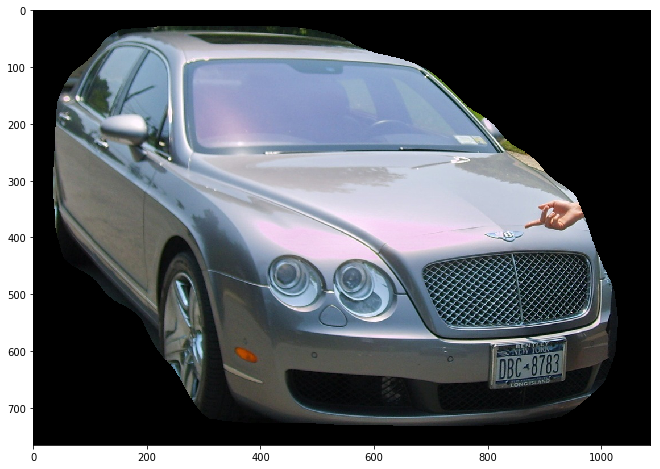

In [18]:
# need to use matplotlib inline if want to show at jupyter Notebook
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(img)
plt.show()